# About Dataset

This classic dataset contains the prices and other attributes of almost 54,000 diamonds. 

Content: 

1. price: price in US dollars (\$326--\$18,823)

2. carat: weight of the diamond (0.2--5.01)

3. cut: quality of the cut (Fair, Good, Very Good, Premium, Ideal)

4. color: diamond colour, from J (worst) to D (best)

5. clarity: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

6. x: length in mm (0--10.74)

7. y: width in mm (0--58.9)

8. z: depth in mm (0--31.8)

9. depth: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

10. table: width of top of diamond relative to widest point (43--95)

# AIMS 


**1. Understand data: content, structure, distribution, dependencies.** 

**2. Validate the pricing model.** 

**3. Get the job.**

# Data Inspection

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats 
from statsmodels.stats.diagnostic import normal_ad, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

!pip install rrcf
import rrcf

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from xgboost import XGBRegressor

!pip install scikit-optimize
from skopt import BayesSearchCV, space, plots

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for rrcf: filename=rrcf-0.4.3-py3-none-any.whl size=9810 sha256=1aca475fe5c7715aae5e4876537c88940de3d842434bfc55f9b97af6641f752f
  Stored in directory: /root/.cache/pip/wheels/38/d5/8c/e5d10c99f3cd7b02453fdb4323dabf1d319203f7f1f2281a4a
Successfully built rrcf
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 5.2 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab/Diamonds/

Mounted at /content/drive
/content/drive/MyDrive/Colab/Diamonds


In [3]:
df = pd.read_csv("data/diamonds.csv")
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## Data Cleaning

In [4]:
df.drop('Unnamed: 0', axis=1, inplace=True) #just rows enumerating

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


There is no missing values.

In [6]:
df.duplicated().sum()

146

In [7]:
df = df.drop_duplicates(keep='first')

There is 146 duplicated rows, so I have dropped them while keeping first occurrences.

In [8]:
df.duplicated().sum()

0

## Exploratory data analysis

### Univariate analysis

In [9]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
carat,53794.0,0.797780,0.473390,0.2,0.40,0.70,1.04,5.01
depth,53794.0,61.748080,1.429909,43.0,61.00,61.80,62.50,79.00
table,53794.0,57.458109,2.233679,43.0,56.00,57.00,59.00,95.00
price,53794.0,3933.065082,3988.114460,326.0,951.00,2401.00,5326.75,18823.00
x,53794.0,5.731214,1.120695,0.0,4.71,5.70,6.54,10.74
y,53794.0,5.734653,1.141209,0.0,4.72,5.71,6.54,58.90
z,53794.0,3.538714,0.705037,0.0,2.91,3.53,4.03,31.80


In [10]:
df.mode(numeric_only=True).transpose()

,0
carat,0.30
depth,62.00
table,56.00
price,605.00
x,4.37
y,4.34
z,2.70


In [11]:
df=df[df['x']!=0]
df=df[df['y']!=0]
df=df[df['z']!=0]

Conclusions: 

1. carat has mean > median so it is right skewed.
2. depth has mean ~ median ~ mode so it is symmetrically distributed. 
3. table has mean ~ median ~ mode so it is symmetrically distributed. 
4. price has mean > median so it is right skewed. 
5. x has mean ~ median > mode so it is right skewed. 
6. y has mean ~ median > mode so it is right skewed. 
7. z has mean ~ median > mode so it is right skewed. 
8. minimum values for size variables are 0 -> it does not have sense, so I have dropped those rows.

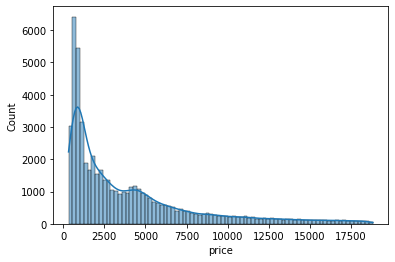

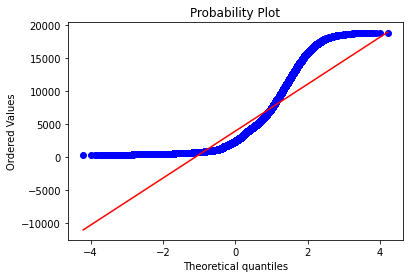

In [12]:
sns.histplot(df['price'], kde=True)
fig = plt.figure()
res = stats.probplot(df['price'], plot=plt)

The diamond price distribution is not Gaussian, it has two peaks.

In [13]:
df.describe(include='object')

,cut,color,clarity
count,53775,53775,53775
unique,5,7,8
top,Ideal,G,SI1
freq,21485,11254,13030


Ideal cut (best), G color (average) and SI1 (good) clarity are more common than others. It could explain 2-peaks distribution of price. 

### Bivariate analysis

Correlation matrix and pairwise relationships plot.

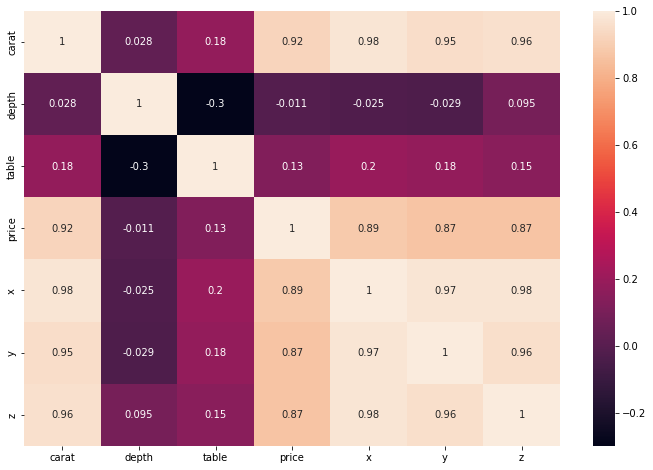

In [14]:
plt.figure(figsize=(12,8))
corr = df.corr()
sns.heatmap(corr, annot=True)
plt.show()

Correlation matrix and pairwise relationships plot.
Very strong correlation between price and carat. Very strong correlation between carat and diamonds' size: x, y, z due to relationships:  $volume \sim x*y*z$ and $carat = density_{diamond}*volume$. Correlation between predictors is redundancy, so x, y, z features will be dropped after outliers detection.

<Figure size 720x720 with 0 Axes>

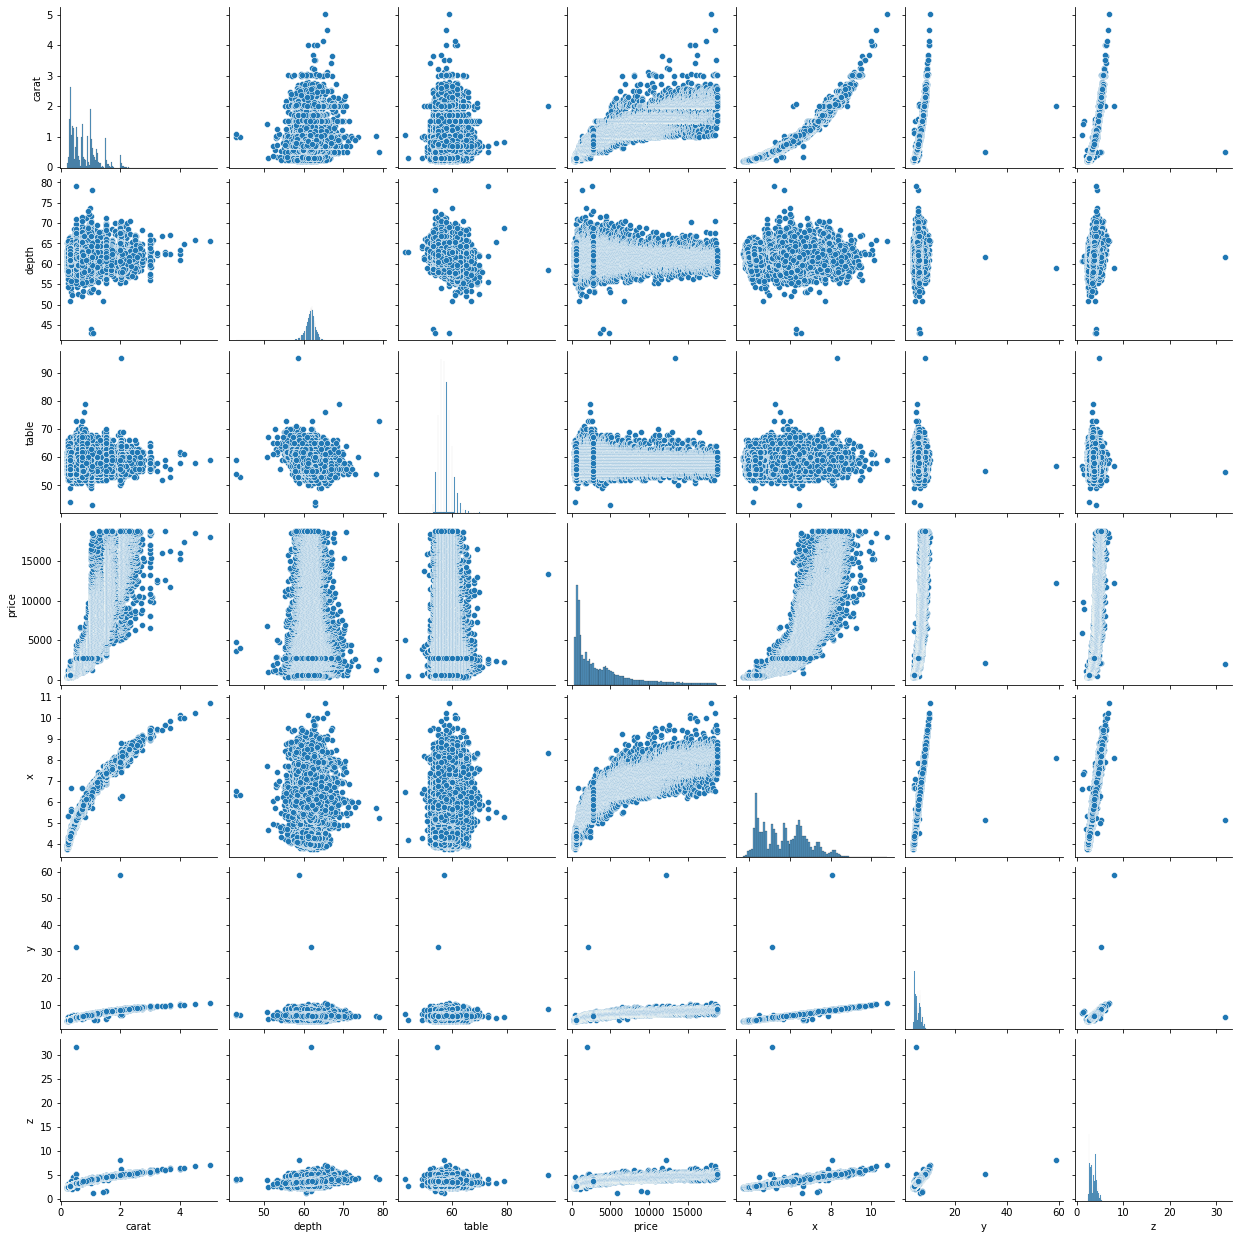

In [15]:
plt.figure(figsize=(10, 10))
sns.pairplot(data=df)
plt.show()

Despite the lack of dependence (almost) between table and price, I will leave the variable as it may somehow explain part of the total variance during training. 

[Text(0.5, 0, 'calculated depth')]

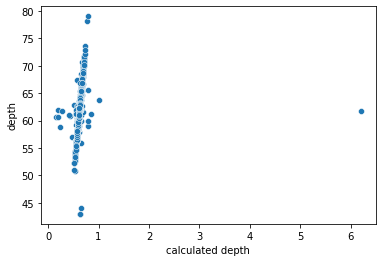

In [16]:
plt.figure(figsize=(6, 4))
depth_calculated = 2 * df['z'] / (df['x'] + df['y'])
ax = sns.scatterplot(x=depth_calculated, y=df['depth'])
ax.set(xlabel='calculated depth')

There is almost no dependence between depth and price and the vast majority of the values follows the equation: $\frac{z}{mean(x, y)}$, so I will drop the variable to avoid any redundancy after I determine outliers. I suspect that points that are not on the straight line are outliers. 

### Checking how categorical variables affect the price

Visualisation of categorical variables on a price vs carat plot (the strongest correlation with price among numerical variables).

<AxesSubplot:xlabel='carat', ylabel='price'>

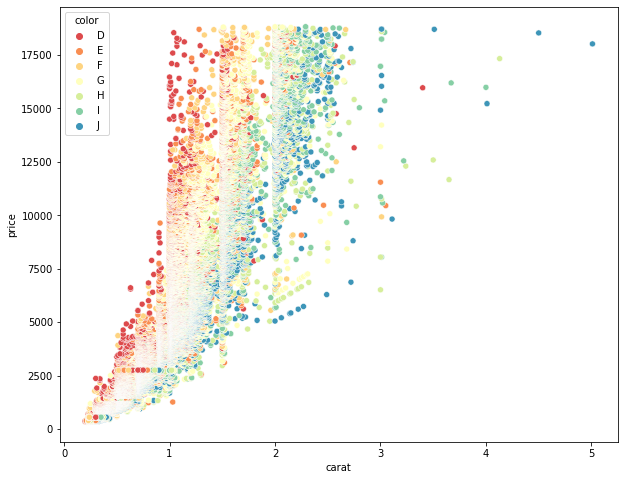

In [17]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='carat', y='price', hue='color', hue_order=list('DEFGHIJ'), palette="Spectral")

<AxesSubplot:xlabel='carat', ylabel='price'>

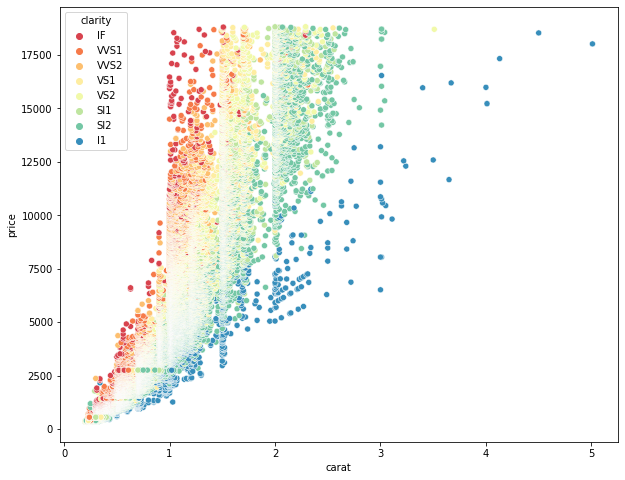

In [18]:
#I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best)
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='carat', y='price', hue='clarity', hue_order=['IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1'], palette="Spectral")

<AxesSubplot:xlabel='carat', ylabel='price'>

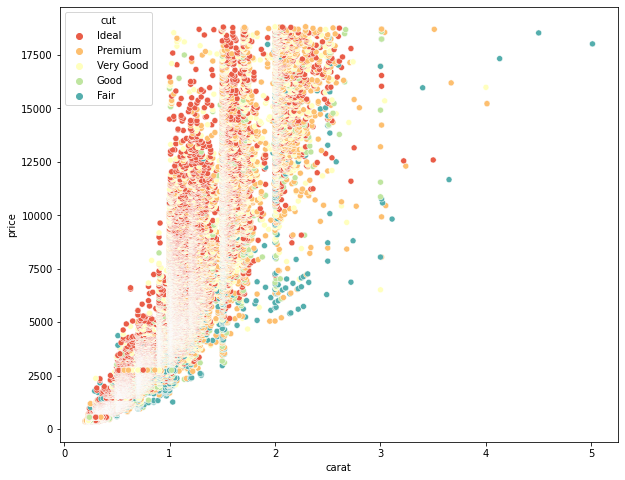

In [19]:
plt.figure(figsize=(10, 8))
sns.scatterplot( data=df, x='carat', y='price', hue='cut', hue_order=['Ideal', 'Premium', 'Very Good', 'Good', 'Fair'], palette="Spectral")

Conclusions:

1. For the same value of carat, the price of the diamonds are higher for better colour, clarity and cuts.
2. The greater the weight (carats) of diamond, the more difficult it is to achieve the perfect colour and clarity, so for greater weights the cut raises the price. 



#### Analitical way to check if variable affect the price

I have used ordinal encoding for categorical feature to keep natural rank ordering. 

In [20]:
# ordinal encoding
dict_cut = dict((k,v) for v, k in enumerate(('Fair', 'Good', 'Very Good', 'Premium', 'Ideal')))
dict_color = dict((k,v) for v, k in enumerate('DEFGHIJ'[::-1]))
dict_clarity = dict((k,v) for v, k in enumerate(('I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF')))

In [21]:
df_ord = df.copy()
df_ord.replace({'cut': dict_cut}, inplace=True)
df_ord.replace({'color': dict_color}, inplace=True)
df_ord.replace({'clarity': dict_clarity}, inplace=True)
df_ord.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,4,5,1,61.5,55.0,326,3.95,3.98,2.43
1,0.21,3,5,2,59.8,61.0,326,3.89,3.84,2.31
2,0.23,1,5,4,56.9,65.0,327,4.05,4.07,2.31
3,0.29,3,1,3,62.4,58.0,334,4.20,4.23,2.63
4,0.31,1,0,1,63.3,58.0,335,4.34,4.35,2.75


In order to measure the correspondence between two variables I have used Kendall’s tau test. A tau of 0 indicates no association and suggests independence. I have used variant "c" - because dependent variable have vast more values than independent variable.

Checking if there is significance correlation between price of different colour.

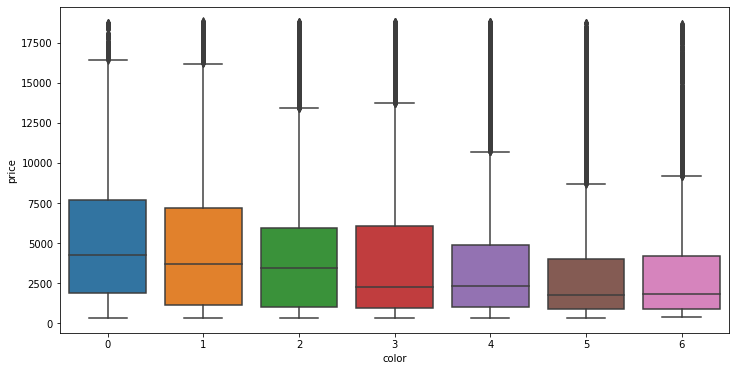

In [22]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_ord["color"], y=df_ord["price"])
plt.show()

In [23]:
def categorical_corr(feature):
  # H_0:  There is an absence of association between variables (corr = 0).
  # H_A:  There is an association between variables.

  alpha = 0.05
  corr = stats.kendalltau(x=df_ord["price"], y=df_ord[feature], variant='c')
  if corr.pvalue < alpha:
    print(f"""Since P value: {corr.pvalue:.2f} is less than alpha: 0.05, 
      I can reject Null Hypothesis that there is an absence of association between price and {feature}.
      The tau coefficient is equal {corr.statistic:.2f}.""")
  else:
    print(f"""Since P value: {corr.pvalue:.2f} is greather than alpha: 0.05, 
      I cannot reject Null Hypothesis that there is an absence of association between price and {feature}.""")

In [24]:
categorical_corr("color")

Since P value: 0.00 is less than alpha: 0.05, 
      I can reject Null Hypothesis that there is an absence of association between price and color.
      The tau coefficient is equal -0.11.


Checking if there is significance correlation between price of different clarity.

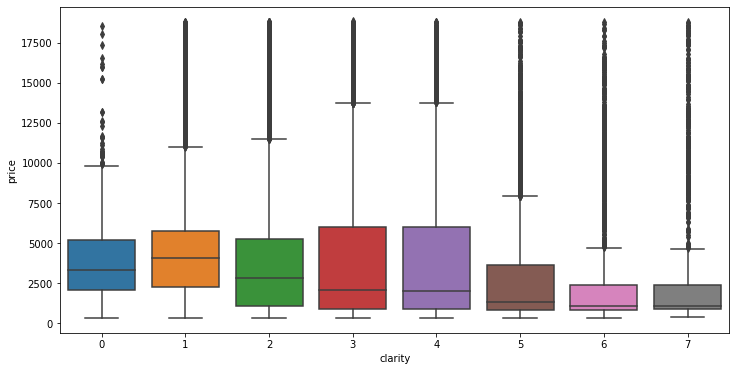

In [25]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_ord["clarity"], y=df_ord["price"])
plt.show()

In [26]:
categorical_corr("clarity")

Since P value: 0.00 is less than alpha: 0.05, 
      I can reject Null Hypothesis that there is an absence of association between price and clarity.
      The tau coefficient is equal -0.15.


Checking if there is significance correlation between price of different cuts.

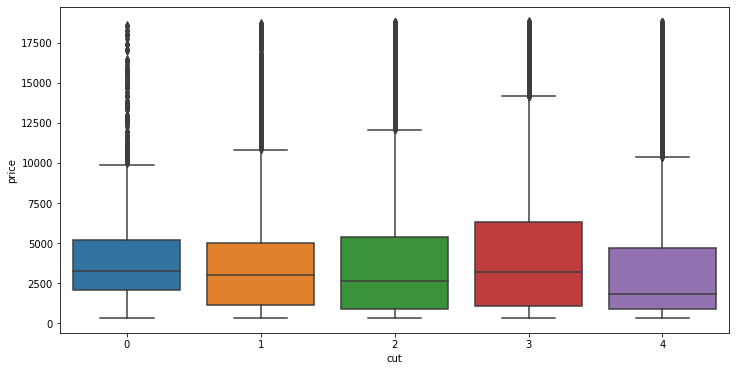

In [27]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_ord["cut"], y=df_ord["price"])
plt.show()

In [28]:
categorical_corr("cut")

Since P value: 0.00 is less than alpha: 0.05, 
      I can reject Null Hypothesis that there is an absence of association between price and cut.
      The tau coefficient is equal -0.07.


Conclusions:  
1. All categorical variables affect the price of diamonds. Negative values of tau-statistic are caused by the inferior quality of the largest, most expensive diamonds. 
2. We have categorical independent variable and continuous dependent variable, which naturally leads to ANOVA analysis. But based on boxplots I can say that there is inequality of variance between the categories, so I can only perform non-parametric Kruskal-Wallis H-test.

The cut's types present less variability in IQRs, so I have performed Bartlett’s test to ensure if is significant difference between variances.

In [29]:
_, p = stats.bartlett(df_ord[['cut', 'price']].groupby(by='cut').get_group(0)['price'], 
                      df_ord[['cut', 'price']].groupby(by='cut').get_group(1)['price'],
                      df_ord[['cut', 'price']].groupby(by='cut').get_group(2)['price'],
                      df_ord[['cut', 'price']].groupby(by='cut').get_group(3)['price'],
                      df_ord[['cut', 'price']].groupby(by='cut').get_group(4)['price'])
if p > 0.05:
  print(f'p value = {p:.2f} suggests that the populations have equal variances.')
else:
  print(f'p value = {p:.2f} suggests that the populations do not have equal variances.')

p value = 0.00 suggests that the populations do not have equal variances.


#### The Kruskal-Wallis H-test 

In [30]:
def kruskal_wallis(feature):
  # H_0:  The median price across different groups is the same.
  # H_A:  At least one of median price is not the same.
 
  alpha = 0.05

  groups = [df_ord[[feature, 'price']].groupby(by=feature).get_group(i)['price'] for i in df_ord[feature].unique()]
  _, p = stats.kruskal(*groups)
  if p < alpha:
    print(f"""Since P value: {p:.2f} is less than alpha: 0.05, 
      I can reject Null Hypothesis that the median price across different {feature} groups is the same.""")
  else:
    print(f"""Since P value: {p:.2f} is greather than alpha: 0.05, 
      I cannot reject Null Hypothesis that the median price across different {feature} groups is the same.""")

In [31]:
kruskal_wallis("color")

Since P value: 0.00 is less than alpha: 0.05, 
      I can reject Null Hypothesis that the median price across different color groups is the same.


In [32]:
kruskal_wallis("clarity")

Since P value: 0.00 is less than alpha: 0.05, 
      I can reject Null Hypothesis that the median price across different clarity groups is the same.


In [33]:
kruskal_wallis('cut')

Since P value: 0.00 is less than alpha: 0.05, 
      I can reject Null Hypothesis that the median price across different cut groups is the same.


#### Checking if categorical variable are independent from each other

I have performed Chi-Square test to determine relationship between categorical variables.

In [34]:
def chi_square(feature_1, feature_2):
  # H0: Variables are independent of each other.
  # Ha: There is a relationship between variables.
        
  alpha = 0.05

  contingency = pd.crosstab(index=df[feature_1], columns=df[feature_2])
  plt.figure(figsize = (20,8))
  # plot proportion of groups from feature_1 across different groups of feature_2
  norm_contigency = contingency.div(contingency.sum(axis=1), axis=0)
  norm_contigency.plot(kind='bar')
  plt.show()
  _, p, _, _ = stats.chi2_contingency(contingency, correction = False)

  if (p < 0.05):
      print(f'Reject Null Hypothesis that {feature_1} is independent of {feature_2}. P-value: {p:.2f}')
  else:
      print(f'Failed to reject Null Hypothesis that {feature_1} is independent of {feature_2}. P-value: {p:.2f}')


<Figure size 1440x576 with 0 Axes>

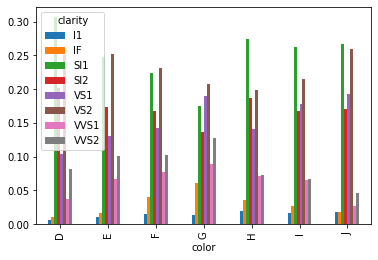

Reject Null Hypothesis that color is independent of clarity. P-value: 0.00


In [35]:
#I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best)
chi_square('color', 'clarity')

Conclusion: The proportion of ideal clarity (IF) reises with better color up to colour G, and then lowers. 

<Figure size 1440x576 with 0 Axes>

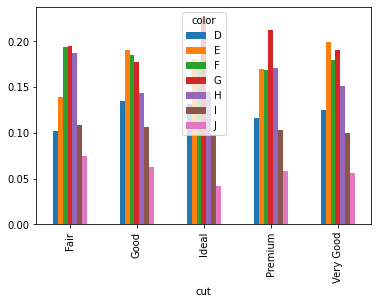

Reject Null Hypothesis that cut is independent of color. P-value: 0.00


In [36]:
chi_square('cut', 'color')

Conclusion: The proportion of average color G for Ideal and Premium cuts is higher than for other cuts.

<Figure size 1440x576 with 0 Axes>

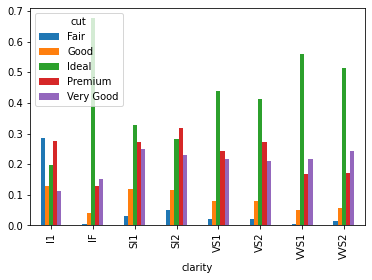

Reject Null Hypothesis that clarity is independent of cut. P-value: 0.00


In [37]:
#I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best)
chi_square('clarity', 'cut')

Conclusion: The proportion of ideal cut for clarity IF is higher than for other clarities. For worst clarity (I1), there is significant higher proportion of worse cuts. 

# Outliers handling

The most robust methods of determining outliers are based on values/distribution of given dataset on the contrary to methods, where contamination should be set by user. These robust methods are among others: z-score, IQR (Interquartile Range), MAD (Median Absolute Deviation), RRCF (Robust Random Cut Forest). Z-score works best on normally distributed data, while IQR, MAD and RRCF require no distribution assumption. Since dataset is small, I can use RRCF without bothering about calculation complexity, as the algorithm uses trees. 

In [38]:
X = df_ord.values

The anomaly score of a point is defined by its collusive displacement, which measures the change in model complexity incurred by inserting or deleting a given point x. An outlier is defined as a point that significantly increases the model complexity when it is included in the tree.



In [39]:
# Set forest parameters
num_trees = 1000
tree_size = 256
n = X.shape[0]
sample_size_range = (n // tree_size, tree_size)

# Construct forest
forest = []
while len(forest) < num_trees:
    # Select random subsets of points uniformly
    ixs = np.random.choice(n, size=sample_size_range,
                           replace=False)
    # Add sampled trees to forest
    trees = [rrcf.RCTree(X[ix], index_labels=ix)
             for ix in ixs]
    forest.extend(trees)

# Compute average CoDisp
avg_codisp = pd.Series(0.0, index=np.arange(n))
index = np.zeros(n)
for tree in forest:
    codisp = pd.Series({leaf : tree.codisp(leaf)
                       for leaf in tree.leaves})
    avg_codisp[codisp.index] += codisp
    np.add.at(index, codisp.index.values, 1)
avg_codisp /= index

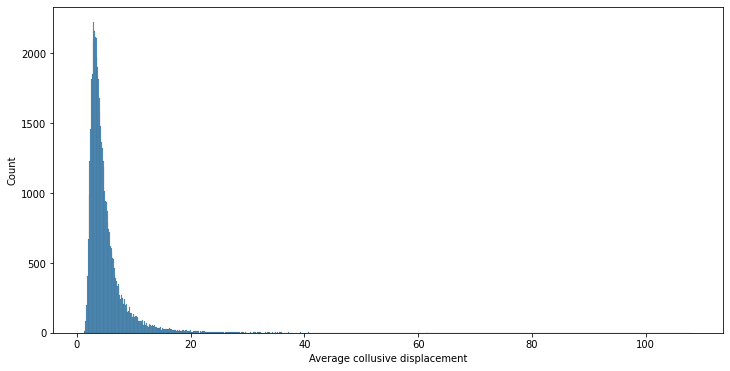

In [40]:
plt.figure(figsize=(12, 6))
ax = sns.histplot(avg_codisp.values)
ax.set(xlabel='Average collusive displacement')
plt.show()

The outliers should significantly differ from inliers, so I have determined threshold as 20.

In [41]:
threshold = 20
mask = (avg_codisp < threshold).values

In [42]:
# percent of outliers
out_percent = (1 - (mask.sum()/len(df_ord)))*100
print(f"RRCF has determined {out_percent:.2f}% data as outliers")

RRCF has determined 1.25% data as outliers


In [43]:
df_ord = df_ord[mask]

Dropping correlated variables after outliers detection to avoid redudancy.

In [44]:
df_ord.drop(columns=['depth', 'x', 'y', 'z'], inplace=True)
df_ord.reset_index(drop=True, inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


# Model selection 

In [45]:
# train-test split
X = df_ord.drop(columns=['price'])
y = df_ord['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2023)

It is always good idea to scale data, when we use gradient-descent-based models. 

In [46]:
# scaler fitted only to testset to avoid data leakage
sc = StandardScaler()
sc.fit(X_train)

X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

I have used one of the simplest models: Linear Regression as starting point, in order to check what problems with data it cannot handle. 

In [47]:
lr = LinearRegression(n_jobs=-1).fit(X_train, y_train)

In [48]:
print(f'R-Squared score for trainset: {lr.score(X_train, y_train):.4f}')

R-Squared score for trainset: 0.9041


About 90% explained variance in trainset.

In [49]:
lr.intercept_

3813.9273375514713

Non-zero intercept cased by categorical features, which raise the price  even when encoded value is 0.

In [50]:
print(f'R-Squared score for testset: {r2_score(y_test, lr.predict(X_test)):.4f}')

R-Squared score for testset: 0.9037


## Checking regression assumptions

### Calculating residuals

In [51]:
predictions = lr.predict(X_train)
summary = pd.DataFrame({'Actual': y_train.values, 'Predicted': predictions})
summary['Residuals'] = summary['Actual'] - summary['Predicted']   

### Linearity

This assumes that there is a linear relationship between the predictors (e.g. independent variables or features) and the response variable (e.g. dependent variable or label). This also assumes that the predictors are additive.

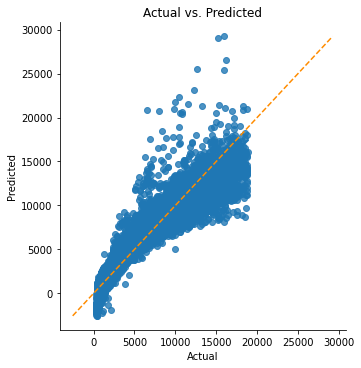

In [52]:
sns.lmplot(x='Actual', y='Predicted', data=summary)
line_coords = np.arange(summary.Predicted.min().min(), summary.Predicted.max().max())
plt.plot(line_coords, line_coords, color='darkorange', linestyle='--')
plt.title('Actual vs. Predicted')
plt.show()

There is not a perfect linear relationship. My predictions are spread especially at the higher values (above 10000). It can be fixed by adding polynomial terms to predictors. 

### Normality of the error terms

Checking normality with Anderson-Darling test.

/usr/local/lib/python3.8/dist-packages/statsmodels/stats/_adnorm.py:70: RuntimeWarning: divide by zero encountered in log1p
  s = np.sum((2 * i[sl1] - 1.0) / nobs * (np.log(z) + np.log1p(-z[sl2])),


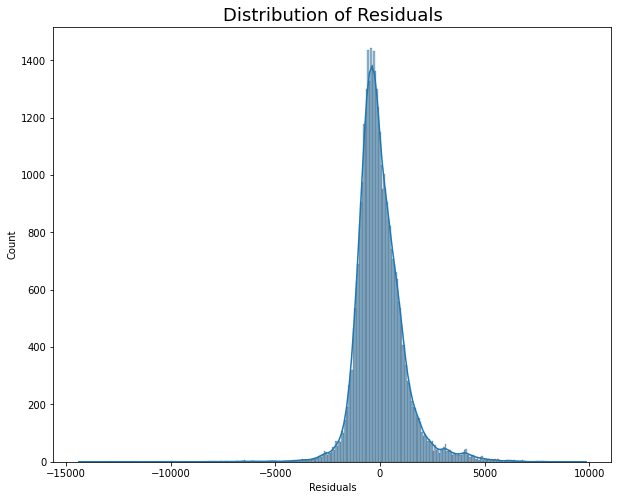

p-value from the Anderson-Darling test: 0.0 means that residuals are not normally distributed.


In [53]:
p_value = normal_ad(summary['Residuals'])[1]

plt.figure(figsize=(10, 8))
plt.title('Distribution of Residuals', fontsize=18)
sns.histplot(summary['Residuals'], kde=True)
plt.show()

if p_value < 0.05:
    print(f'p-value from the Anderson-Darling test: {p_value} means that residuals are not normally distributed.')
else:
    print(f'p-value from the Anderson-Darling test: {p_value} means that residuals are normally distributed.')

The model is biasing towards over-estimating.

### Multicollinearity

Multicollinearity assumes that predictors are not correlated with each other. If there is correlation among the predictors, then either remove predictors with high Variance Inflation Factor (VIF) values or perform dimensionality reduction.

In [54]:
VIF = [variance_inflation_factor(X_train, i) for i in range(X_train.shape[1])]
print("VIF for regressors:")
for idx, vif in enumerate(VIF):
    print(f'{X.columns[idx]}: {vif:.2f}')
        
# Gathering and printing total cases of possible or definite multicollinearity
possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
definite_multicollinearity = sum([1 for vif in VIF if vif > 100])

print(f'{possible_multicollinearity} cases of possible multicollinearity')
print(f'{definite_multicollinearity} cases of definite multicollinearity')

VIF for regressors:
carat: 1.30
cut: 1.26
color: 1.12
clarity: 1.20
table: 1.26
0 cases of possible multicollinearity
0 cases of definite multicollinearity


### Autocorrelation of the error terms

This assumes no autocorrelation of the error terms. Autocorrelation being present typically indicates that we are missing some information that should be captured by the model. It can be checked by Durbin-Watson test.

In [55]:
from statsmodels.stats.stattools import durbin_watson
db = durbin_watson(summary['Residuals'])
print('Durbin-Watson:', db)
if db < 1.5:
  print('Signs of positive autocorrelation', '\n')
  print('Assumption not satisfied')
elif db > 2.5:
  print('Signs of negative autocorrelation', '\n')
  print('Assumption not satisfied')
else:
  print('Little to no autocorrelation', '\n')
  print('Assumption satisfied')

Durbin-Watson: 1.9886595265826335
Little to no autocorrelation 

Assumption satisfied


### Homoscedasticity

The violation of homoscedasticity, occurs when we don’t have an even variance across the error terms. I have performed Kolmogorov-Smirnov test for goodness of fit to determine homoscedasticity of error terms. 

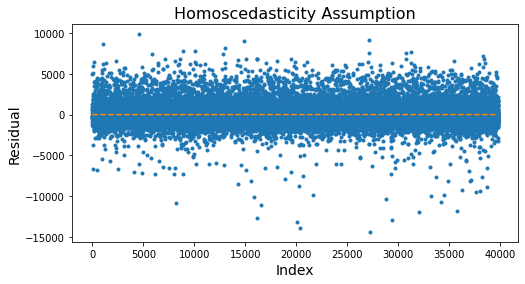

In [56]:
# Plotting the residuals
plt.subplots(figsize=(8, 4))
summary['Residuals'].plot(style='.')
plt.plot(np.repeat(summary['Residuals'].mean(), len(summary)+2), color='darkorange', linestyle='--')

plt.ylabel('Residual', fontsize=14)
plt.xlabel('Index', fontsize=14)
plt.title('Homoscedasticity Assumption', fontsize=16)
plt.show()  


In [ ]:
stats.kstest(summary['Residuals'].values, np.repeat(summary['Residuals'].mean(), len(summary)))

KstestResult(statistic=0.5735796882855706, pvalue=0.0, statistic_location=-0.11266694229652785, statistic_sign=1)

~~The Kolmogorov-Smirnov test indicates a heteroscedasticity.~~ I used this test incorrectly. I only checked if the sample's CDF is ~ 0 (what does not have sense, by the way). To check for heteroscedasticity I should have used the Breusch-Pagan test.

In [60]:
pval = het_breuschpagan(summary['Residuals'].values, X_train)[1]

if pval > 0.05:
  print("Null hypothesis cannot be rejected: The residuals are uniformly scattered (homoscedasticity).")
else:
  print("Null hypothesis can be rejected: heteroskedasticity detected.")

Null hypothesis can be rejected: heteroskedasticity detected.


## Hybrid model

Regression's Linearity, Normality and Homoscedasticity assumptions are violated due to non-linear relantionship between input variables and output. It could be fixed by transforming data to satisfy these assumptions or changing the model. But my approch is to keep Linear Regression results as a baseline and use XGBoost model to learn non-linear dependecies from residuals. It can be also beneficial  because XGBoost cannot extrapolate results beyond values from trainset and Regression can. Generally, it is naive approch to extrapolate results outside trainset, but poor extrapolation is better than no extrapolation.

# Model training

In [ ]:
xgb_y_train = summary['Residuals'].values

In [ ]:
xgb = XGBRegressor(n_jobs=-1).fit(X_train, xgb_y_train)

In [ ]:
xgb.score(X_train, xgb_y_train) 

0.8719804739678497




# Model validation 

In [ ]:
predictions = lr.predict(X_test) + xgb.predict(X_test)

In [ ]:
print(f'R-Squared score for trainset: {r2_score(y_test, predictions):.4f}')

R-Squared score for trainset: 0.9808


OK, it works. Let me check if I can better.

# Model improvement 

I have used Hyperparameter Tuning with Bayesian Optimization, to search best models' hyperparameters. It is more flexible approach than Grid Search or Random Search as parameter selection in each iteration is based on the previous iteration score, so optimal parameters can be  reached faster.

In [ ]:
#30 min
clf = XGBRegressor()

params = {
    'learning_rate': space.Real(1e-4, 1, prior='log-uniform'),
    'n_estimators': space.Integer(100, 500),
    'max_depth': space.Integer(2, 10)
}

search = BayesSearchCV(clf, params, cv=5,
                       verbose=0, n_jobs=-1,
                       n_iter=50)

search.fit(X_train, xgb_y_train)

clf.set_params(**search.best_params_)

In [ ]:
search.best_params_

OrderedDict([('learning_rate', 0.0901814456558286),
             ('max_depth', 8),
             ('n_estimators', 100)])

In [ ]:
search.best_score_

0.8057417970055859

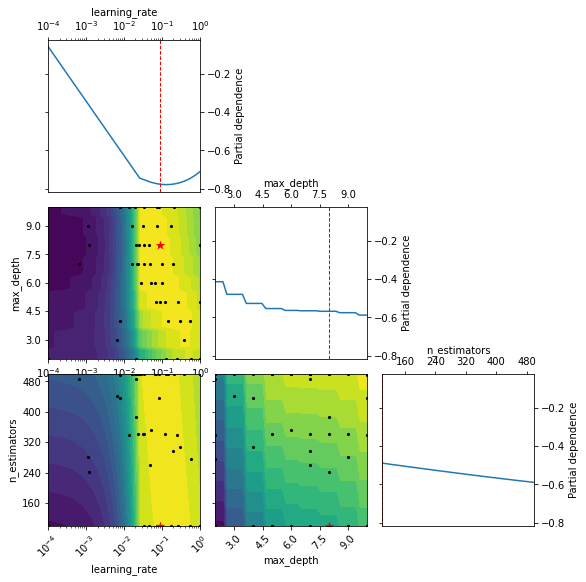

In [ ]:
# visualize searching process
plots.plot_objective(search.optimizer_results_[0], size=2.5, levels=25)
plt.show()

In [ ]:
clf.fit(X_train, xgb_y_train)

In [ ]:
predictions = lr.predict(X_test) + clf.predict(X_test)

In [ ]:
print(f'Final R-Squared score for trainset: {r2_score(y_test, predictions):.4f}')

Final R-Squared score for trainset: 0.9813


After hyperparameter tuning model performs slightly better. My model explained over 98% of variance in the price.